#Section 2 project
##머신러닝을 이용한 영화 추천 알고리즘

##주제 선택 배경  
- 요즘 넷플릭스를 필두로 OTT 시장이 급격하게 성장함에 따라, 많은 컨텐츠 소유기업(디즈니, 워너브라더스 등)들도 자체적인 OTT서비스를 내놓기 시작했다. 각각의 서비스는 대중이 서비스를 계속 구독하도록 하기 위해 유저인터페이스에 적용되는 다양한 추천알고리즘을 운용하고 있다.
- 고전영화부터 신작영화까지 다양한 영화들이 스트리밍 시스템에 업데이트 되고 있으며, 사용자들에게 추천알고리즘을 띄우기 전 해당 영화가 추천 할만한 수준의 완성도를 가지고 있는 지를 예측하는 시스템을 만들 것이다.
- 스트리밍 이용자가 추천영화를 봤을 때, 느끼는 만족도가 더 커질 수록 추천알고리즘을 이용하는 경우가 더 많아질 것이며, 이는 서비스의 이용률 증가로 이어질 것이다. 


In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap
    !pip install --upgrade scikit-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 선정  
kaggle에 올라온 IMDB(미국 영화 데이터베이스) 자료를 다운

In [4]:
df_movies = pd.read_csv('/content/drive/My Drive/Code/IMDb movies.csv')
df_ratings = pd.read_csv('/content/drive/My Drive/Code/IMDb ratings.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df_ratings = df_ratings[['imdb_title_id','males_18age_avg_vote','males_30age_avg_vote','females_18age_avg_vote','females_30age_avg_vote']]

In [6]:
df_movies.shape

(85855, 22)

In [7]:
df_movies = df_movies.merge(df_ratings,on='imdb_title_id')

In [87]:
df_movies.columns

Index(['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics'],
      dtype='object')

In [8]:
df_movies.shape

(85855, 26)

In [9]:
df_movies.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,males_18age_avg_vote,males_30age_avg_vote,females_18age_avg_vote,females_30age_avg_vote
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0,5.9,5.6,5.9,5.7
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0,6.2,6.0,5.9,6.2
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,"Urban Gad, Gebhard Schätzler-Perasini",Fotorama,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0,5.5,5.9,5.8,5.8
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,$ 45000,NaN,NaN,NaN,25.0,3.0,5.2,4.9,5.7,5.5
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",Dante Alighieri,Milano Film,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,NaN,NaN,NaN,NaN,31.0,14.0,7.0,7.0,7.0,7.3


In [10]:
df_movies.shape

(85855, 26)

## 문제 정의

해당 dataset에서 관람자의 만족도를 가장 잘 반영하는 feature는 avg_vote(평균 평점 1~10)일 것이다. 분포를 살펴보면,

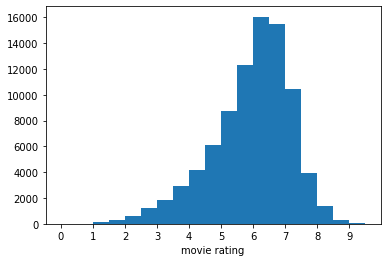

In [89]:
sns.histplot(data=df_movies.avg_vote)
plt.xlabel('Movie rating')
plt.xticks(np.arange(0, 10, step=0.5));

rating 6.5점을 의 벽을 기준으로 그저그런 영화와 잘 만든영화가 구분되는 것을 관찰 할 수 있다. 따라서 입력되는 영화의 정보들을 모델에 학습시켜, 6.5점이 넘을 것으로 예상된다면 True(추천), 그렇지 않다면 False(비추천)으로 분류하는 classification 알고리즘을 만들어보자.  
(baseline 모델은 머신러닝 모델링 파트 직전에 만들 예정) 

## EDA & Feature Engineering

In [12]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85855 entries, 0 to 85854
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   imdb_title_id           85855 non-null  object 
 1   title                   85855 non-null  object 
 2   original_title          85855 non-null  object 
 3   year                    85855 non-null  object 
 4   date_published          85855 non-null  object 
 5   genre                   85855 non-null  object 
 6   duration                85855 non-null  int64  
 7   country                 85791 non-null  object 
 8   language                85022 non-null  object 
 9   director                85768 non-null  object 
 10  writer                  84283 non-null  object 
 11  production_company      81400 non-null  object 
 12  actors                  85786 non-null  object 
 13  description             83740 non-null  object 
 14  avg_vote                85855 non-null

먼저 결측치가 과다하게 많은 budget, usa_gross_income, worlwide_gross_income, metascore는 feature에서 제거한다.

추가적으로 모델 training에서 제거할 feature들은 다음과 같다.
- votes(평점 득표 수)의 경우 대중성을 반영하는 좋은 척도가 될 수 있지만, leakage issue를 유발할 수 있으므로 삭제한다. 
- title, original_title은 고유값이므로 제외한다.
- date_published정보는 year로 대체 가능
- language는 country로 대체 가능
- 이 모델에서는 평점(Rating)만 활용할 것이므로, review 정보는 제외한다(reviews_from_users, reviews_from_critics)
- description 아주 좋은 정보지만, 아직 내 머신러닝 모델링 스킬이 부족하므로 삭제한다.


In [13]:
df_movies = df_movies.drop(columns = ['imdb_title_id','budget','usa_gross_income','worlwide_gross_income','metascore',
                                      'reviews_from_users','reviews_from_critics','title','original_title','date_published','language','description'])

데이터의 feature를 더 자세히 살펴보며 전처리를 진행해보자

In [14]:
df_movies['year'].unique()

array([1894, 1906, 1911, 1912, 1919, 1913, 1914, 1915, 1916, 1917, 1918,
       1920, 1921, 1924, 1922, 1923, 1925, 1926, 1935, 1927, 1928, 1983,
       1929, 1930, 1932, 1931, 1937, 1938, 1933, 1934, 1936, 1940, 1939,
       1942, 1943, 1941, 1948, 1944, 2001, 1946, 1945, 1947, 1973, 1949,
       1950, 1952, 1951, 1962, 1953, 1954, 1955, 1961, 1956, 1958, 1957,
       1959, 1960, 1963, 1965, 1971, 1964, 1966, 1968, 1967, 1969, 1976,
       1970, 1979, 1972, 1981, 1978, 2000, 1989, 1975, 1974, 1986, 1990,
       2018, 1977, 1982, 1980, 1993, 1984, 1985, 1988, 1987, 2005, 1991,
       2002, 1994, 1992, 1995, 2017, 1997, 1996, 2006, 1999, 1998, 2007,
       2008, 2003, 2004, 2010, 2009, 2011, 2013, 2012, 2016, 2015, 2014,
       2019, 2020, '2012', '2015', '2009', '2013', '2018', '2014', '2017',
       '2011', '2016', '1981', '1975', '2010', '1984', '2007', '2006',
       '2001', '2004', '1979', '2019', '1967', '1978', '2003', '2005',
       '1969', '1990', '1983', '2002', '1996', '2008'

'TV movie 2019' 라는 특이 data가 보인다. 2019로 바꿔주자

In [15]:
df_movies['year'] = df_movies['year'].replace('TV Movie 2019',2019)

In [16]:
# 'year' column을 object 에서 numeric으로 변경
df_movies['year'] = pd.to_numeric(df_movies['year'])

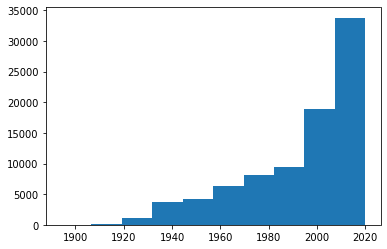

In [17]:
plt.hist(df_movies['year']);

최신 트렌드 반영을 위하여, 1990년대 이후의 영화만 집계하도록 한다.

In [18]:
#year 1990 이상만 다시 저장
df_movies = df_movies[(df_movies.year >= 1990)]

In [19]:
df_movies = df_movies.dropna(subset=['director','writer','actors','country','production_company'])

폐쇄적인 취향을 가지고 있는 india 영화도 모델의 성능을 위해서 제거한다.

In [20]:
df_movies = df_movies[~df_movies.country.str.contains("India")]
#df_movies = df_movies[~df_movies.country.str.contains("China")]

In [21]:
df_movies.shape

(47840, 14)

Duration(상영시간의 경우), 영화가 너무 길면, 거부감을 발생시킬 수 있으므로, 99.8 percentile로 극단치를 제거하도록 한다. 

In [22]:
df_movies.duration.describe()

count    47840.000000
mean        98.864110
std         17.537526
min         42.000000
25%         89.000000
50%         96.000000
75%        106.000000
max        808.000000
Name: duration, dtype: float64

In [23]:
temp1 = np.percentile(df_movies.duration,99.8)
temp2 = np.percentile(df_movies.duration,0.02)

In [24]:
df_movies = df_movies[(df_movies.duration <= temp1) & (df_movies.duration >= temp2)]

In [25]:
df_movies.nunique()

year                         31
genre                       876
duration                    139
country                    4147
director                  24246
writer                    39024
production_company        22192
actors                    47722
avg_vote                     85
votes                     11955
males_18age_avg_vote         91
males_30age_avg_vote         88
females_18age_avg_vote       91
females_30age_avg_vote       91
dtype: int64

남은 feature들의 경우 대부분 고유명사(이름, 명칭) 이므로 매우 큰 cardinality를 가지고 있다. feature 별로 cardinality를 줄일 수 있는 방법을 가정해보고 적용해보자

In [26]:
df_movies.genre

4334     Comedy, Fantasy, Romance
14127               Action, Crime
14739             Drama, Thriller
15675                       Drama
19545        Comedy, Crime, Drama
                   ...           
85846                         War
85850                      Comedy
85851               Comedy, Drama
85853               Drama, Family
85854                       Drama
Name: genre, Length: 47742, dtype: object

Genre의 경우 ', ' 를 나눠서 cadinality를 다시 계산 가능하다

In [27]:
genres = []
for i in df_movies.genre:
  temp = i.split(', ')
  for j in temp:
    if j in genres:
      continue
    else:
      genres.append(j)

In [28]:
#Genre의 실제 cardinality
genres

['Comedy',
 'Fantasy',
 'Romance',
 'Action',
 'Crime',
 'Drama',
 'Thriller',
 'Family',
 'Biography',
 'History',
 'Horror',
 'Sci-Fi',
 'Mystery',
 'Adventure',
 'War',
 'Music',
 'Western',
 'Animation',
 'Sport',
 'Musical',
 'Reality-TV',
 'News']

country도 마찬가지로 처리

In [29]:
countries = []
for i in df_movies.country:
  temp = i.split(', ')
  for j in temp:
    if j in countries:
      continue
    else:
      countries.append(j)

각 genre와 country 에 해당하는 binary column을 만들어 encoding 효과를 만들어 낼 수 있다.

In [30]:
for i in genres:
  df_movies[i] = np.where(df_movies['genre'].str.contains(i),1,0)
for i in countries:
  df_movies[i] = np.where(df_movies['country'].str.contains(i),1,0)

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [31]:
df_movies[list(df_movies.columns[12:])]

,females_18age_avg_vote,females_30age_avg_vote,Comedy,Fantasy,Romance,Action,Crime,Drama,Thriller,Family,Biography,History,Horror,Sci-Fi,Mystery,Adventure,War,Music,Western,Animation,Sport,Musical,Reality-TV,News,USA,Japan,Czechoslovakia,France,Iran,Canada,Portugal,Tunisia,Italy,Brazil,Hong Kong,Venezuela,Taiwan,Poland,Russia,Philippines,...,North Korea,British Virgin Islands,Trinidad and Tobago,Myanmar,Rwanda,Uganda,Liberia,Ethiopia,Kuwait,Azerbaijan,Mauritius,New Caledonia,Panama,Papua New Guinea,Honduras,Nicaragua,Netherlands Antilles,Reunion,Samoa,Lesotho,Swaziland,Montenegro,Laos,Syria,Equatorial Guinea,Tanzania,Brunei,Somalia,El Salvador,Vanuatu,Bermuda,Sudan,Belize,Cook Islands,Maldives,Djibouti,Guadeloupe,Malawi,Holy See (Vatican City State),Zimbabwe
4334,6.7,6.5,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14127,7.0,5.8,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14739,8.2,7.8,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15675,6.9,6.1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19545,7.8,5.1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85846,5.2,5.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
85850,6.2,5.7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
85851,7.4,8.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
85853,NaN,NaN,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


director(감독), writer(각본), actor(배우)의 경우, 이름값이 들어가 있으므로 cardinality를 다루기가 매우 까다롭다. 이번 모델에서는 다음과 같은 가정을 한다.

1. dataset에서 director, writer, actor가 감독,각본,출연한 영화가 많을수록 score가 올라간다.
2. 영화의 맡은 director, writer는 이름 대신 그 이름이 가지고 있는 score로 대체(공동 감독, 각본일 경우, max로 한다.). actor의 경우 출연자들 score의 평균으로 대체한다.

In [32]:
#director, writer, actor 이름들을 가지고 있는 raw list를 생성

directors = []
writers = []
actors = []
production_companies = []

for i in df_movies.director:
  temp = i.split(', ')
  for j in temp:
    directors.append(j)
    
for i in df_movies.writer:
  temp = i.split(', ')
  for j in temp:
    writers.append(j)

for i in df_movies.actors:
  temp = i.split(', ')
  for j in temp:
    actors.append(j)

for i in df_movies.production_company:
  temp = i.split(', ')
  for j in temp:
    production_companies.append(j)

In [33]:
# dataset에서 등장한 횟수(score)를 이름에 매칭시키는 dictionary로 저장

from collections import Counter

#sorted(Counter(directors).values(),reverse=True)

director_score_list = Counter(directors) 
writer_score_list = Counter(writers)
actor_score_list = Counter(actors)
production_companies_list = Counter(production_companies)

In [74]:
director_score_list

Counter({'James Mangold': 11,
         'Kinji Fukasaku': 6,
         'Karel Kachyna': 5,
         'Orson Welles': 2,
         'Dan Curtis': 1,
         'Michael Rubbo': 2,
         'Manoel de Oliveira': 22,
         'Wayne Berwick': 1,
         'Ted Newsom': 1,
         'Férid Boughedir': 2,
         'Ivan Cardoso': 2,
         'Charlie Wiener': 1,
         'Andrew Lau': 36,
         'Chuen-Yee Cha': 3,
         'Marco Ferreri': 4,
         'William A. Levey': 1,
         'Lucio Fulci': 4,
         'Luis Alberto Lamata': 2,
         'Ho Yim': 7,
         'Hark Tsui': 29,
         'Karl Armstrong': 1,
         'Paul Ziller': 8,
         'Menahem Golan': 8,
         'Frankie Chan': 2,
         'Fred Olen Ray': 36,
         'Eric Tsang': 3,
         'Álvaro Sáenz de Heredia': 5,
         'Tonino Cervi': 1,
         'Alain Robak': 1,
         'Dennis Hopper': 3,
         'Alec Mills': 2,
         'James Allen': 1,
         'Bill Milling': 1,
         'Leonid Gaidai': 2,
         'Éric Rohm

In [35]:
#해당 dataset의 이름을 score로 교체

df_movies['director_score'] = [max(director_score_list[j] for j in i.split(', ')) for i in df_movies.director]
df_movies['writer_score'] = [max(writer_score_list[j] for j in i.split(', ')) for i in df_movies.writer]
df_movies['actor_score'] = [ sum(actor_score_list[j] for j in i.split(', ')) / len(i.split(', ')) for i in df_movies.actors]
df_movies['production_company_score'] = [production_companies_list[i] for i in df_movies.production_company]

In [36]:
#encoding이 완료된 feature들을 제거
df_movies = df_movies.drop(columns=['director','writer','production_company','actors','genre','country'])

In [37]:
df_movies.head()

,year,duration,avg_vote,votes,males_18age_avg_vote,males_30age_avg_vote,females_18age_avg_vote,females_30age_avg_vote,Comedy,Fantasy,Romance,Action,Crime,Drama,Thriller,Family,Biography,History,Horror,Sci-Fi,Mystery,Adventure,War,Music,Western,Animation,Sport,Musical,Reality-TV,News,USA,Japan,Czechoslovakia,France,Iran,Canada,Portugal,Tunisia,Italy,Brazil,...,Rwanda,Uganda,Liberia,Ethiopia,Kuwait,Azerbaijan,Mauritius,New Caledonia,Panama,Papua New Guinea,Honduras,Nicaragua,Netherlands Antilles,Reunion,Samoa,Lesotho,Swaziland,Montenegro,Laos,Syria,Equatorial Guinea,Tanzania,Brunei,Somalia,El Salvador,Vanuatu,Bermuda,Sudan,Belize,Cook Islands,Maldives,Djibouti,Guadeloupe,Malawi,Holy See (Vatican City State),Zimbabwe,director_score,writer_score,actor_score,production_company_score
4334,2001,118,6.4,77852,6.5,6.2,6.7,6.5,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,5,18.866667,1
14127,2000,97,7.0,168,6.5,7.3,7.0,5.8,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,3,2.133333,33
14739,1990,94,7.8,2418,7.9,7.8,8.2,7.8,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,2,2.066667,3
15675,2018,122,6.8,5887,7.3,6.7,6.9,6.1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2.933333,3
19545,1993,94,5.4,242,5.8,5.4,7.8,5.1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,11.733333,1


In [38]:
df_movies.shape

(47742, 216)

머신러닝 모델을 만들기에 앞서, 무작위로 추천/비추천을 했을 때의 정답률을 확률적으로 가정하기 위해, baseline 모델의 점수를 확인해보자

In [39]:
#df_movies.columns

In [40]:
#추천하는 대상의 성향에 따라 target 점수가 달라질 수 있다.
target_list = ['avg_vote','males_18age_avg_vote','males_30age_avg_vote','females_18age_avg_vote','females_30age_avg_vote']

In [41]:
#이번 모델은 모든 사용자의 점수를 기준으로 만든다.
target = 'avg_vote'

In [42]:
target_list.remove(target)

In [43]:
df_movies = df_movies.drop(columns =target_list)

In [44]:
df_movies = df_movies.drop(columns ='votes')             

In [45]:
df_movies = df_movies.dropna(subset=[target])

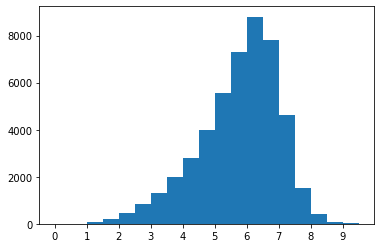

In [46]:
plt.hist(df_movies.avg_vote,bins=np.arange(0,10,0.5))
plt.xticks(np.arange(0, 10, step=1));

추천 classification을 위해 6.5 이상은 True 그 이하는 False로 값을 변경해준다.

In [47]:
#rating 6.5 이상은 true, 그 이하는 false로 avg_vote값을 변경 
df_movies[target] = (df_movies[target] >= 6.5)
#df_movies[target].value_counts(normalize=True)

무작위로 pass/fail을 데이터셋에 적용하는 baseline 모델을 가정하고 그 점수를 확인 

In [48]:
df_movies[target].value_counts(normalize=True)

False    0.697436
True     0.302564
Name: avg_vote, dtype: float64

baseline 점수는 위와 같다

이제 머신러닝 API에 적용해보자.
먼저 train/validation/test set 분리에 있어서는, dimension 대비 dataset의 수가 충분하다고 판단되므로, 3-way holdout method를 적용한다

In [49]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_movies, test_size=4000, 
                              stratify=df_movies[target], random_state=2)
train.shape, test.shape

((43742, 211), (4000, 211))

In [50]:
train, val = train_test_split(train, test_size=4000, 
                              stratify=train[target], random_state=2)

train.shape, val.shape , test.shape

((39742, 211), (4000, 211), (4000, 211))

In [51]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

먼저 적용하는 알고리즘은 XGBclassifier(Gradient Boost Classifier) 이다. early stopping으로 적당한 hyperparameter를 추정할 수 있다.

In [83]:
from xgboost import XGBClassifier
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

#0.697436 / 0.302564
ratio = 0.35
pipe = XGBClassifier(n_estimators=300
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2
                  ,scale_pos_weight=ratio
                 )

eval_set = [(X_train, y_train), 
            (X_val, y_val)]

pipe.fit(X_train, y_train, 
          eval_set=eval_set,
          eval_metric='error', # #(wrong cases)/#(all cases)
          early_stopping_rounds=50
         ) # 50 rounds 동안 스코어의 개선이 없으면 멈춤

[0]	validation_0-error:0.279352	validation_1-error:0.281
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.278572	validation_1-error:0.28375
[2]	validation_0-error:0.276383	validation_1-error:0.2815
[3]	validation_0-error:0.276911	validation_1-error:0.28225
[4]	validation_0-error:0.276207	validation_1-error:0.28425
[5]	validation_0-error:0.276156	validation_1-error:0.2835
[6]	validation_0-error:0.276005	validation_1-error:0.28325
[7]	validation_0-error:0.275552	validation_1-error:0.2835
[8]	validation_0-error:0.275628	validation_1-error:0.28375
[9]	validation_0-error:0.275678	validation_1-error:0.284
[10]	validation_0-error:0.275452	validation_1-error:0.28425
[11]	validation_0-error:0.274194	validation_1-error:0.28375
[12]	validation_0-error:0.27364	validation_1-error:0.283
[13]	validation_0-error:0.273464	validation_1-error:0.283
[14]	validation_0-err

XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=300, n_jobs=-1,
              random_state=2, scale_pos_weight=0.35)

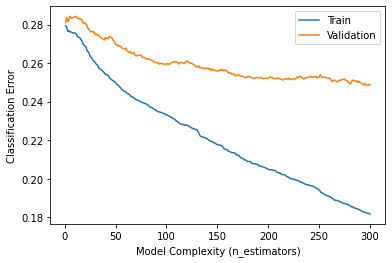

In [84]:
results = pipe.evals_result()
train_error = results['validation_0']['error']
val_error = results['validation_1']['error']

epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.legend();

In [85]:
from sklearn.metrics import accuracy_score

y_pred = pipe.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))

검증 정확도:  0.7515


In [86]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.75      0.96      0.84      2790
        True       0.75      0.27      0.39      1210

    accuracy                           0.75      4000
   macro avg       0.75      0.61      0.62      4000
weighted avg       0.75      0.75      0.71      4000



여기서 의도적으로 scale_pos_weight의 ratio를 매우 작게 주어, recall 점수를 낮게 가져가고 precision 점수를 높게 가져간 이유는 다음과 같다.
- 4000개의 테스트셋에서 실제로 추천받을 만한 영화를 얼마나 많이 가려냈는지 보다는(recall)
- 고객한테 추천영화로 분류된 영화를 추천했을 때, 그 영화가 실제로 추천할만한 영화인지를 나타내는 확률(precision)이 더 중요하기 때문이다.

두번째로 적용하는 알고리즘은 XGBRFclassifier(Random Forest Classifier) 이다.

In [56]:
from xgboost import XGBRFClassifier

#0.187654 / 0.812346
ratio = 0.812346 / 0.187654
pipe2 = XGBRFClassifier(n_estimators=300
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2
                  ,scale_pos_weight=ratio
                 )

eval_set = [(X_train, y_train), 
            (X_val, y_val)]

pipe2.fit(X_train, y_train, 
          eval_set=eval_set,
          eval_metric='error', # #(wrong cases)/#(all cases)
          early_stopping_rounds=50
         ) # 50 rounds 동안 스코어의 개선이 없으면 멈춤

[0]	validation_0-error:0.390896	validation_1-error:0.40875
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.


XGBRFClassifier(learning_rate=0.2, max_depth=7, n_estimators=300, n_jobs=-1,
                random_state=2, scale_pos_weight=4.328956483741354)

In [111]:
y_pred2 = pipe2.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred2))

검증 정확도:  0.59125


In [110]:
print(classification_report(y_val, y_pred2))

              precision    recall  f1-score   support

       False       0.90      0.47      0.61      2790
        True       0.42      0.88      0.57      1210

    accuracy                           0.59      4000
   macro avg       0.66      0.67      0.59      4000
weighted avg       0.75      0.59      0.60      4000



XGBclassifier 모델과 random forest model을 비교해본 결과, 전반적으로 XGBclassifier이 우수한 것을 알 수 있다.  
따라서 XGbclassifier 모델로 최종 test 모델을 시험해보고, SHAP로 어떤 속성들이 영향을 끼쳤는지 알아보자

In [112]:
#먼저 test set에서의 성능 시험
from sklearn.metrics import accuracy_score

y_pred = pipe.predict(X_test)
print('검증 정확도: ', accuracy_score(y_test, y_pred))

검증 정확도:  0.75175


In [113]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.75      0.96      0.84      2790
        True       0.75      0.27      0.40      1210

    accuracy                           0.75      4000
   macro avg       0.75      0.62      0.62      4000
weighted avg       0.75      0.75      0.71      4000



In [77]:
print('baseline model을 약 0.05정도 상회하였다.')

baseline model을 약 0.04정도 상회하였다.


이제 shap library를 이용하여 어떤 feature가 classification에 크게 영향을 끼치는지 살펴보자

In [62]:
#index 41933, 해당 영화에 대한 shap 검증 진행
df_movies.iloc[[41933]]

,year,duration,avg_vote,Comedy,Fantasy,Romance,Action,Crime,Drama,Thriller,Family,Biography,History,Horror,Sci-Fi,Mystery,Adventure,War,Music,Western,Animation,Sport,Musical,Reality-TV,News,USA,Japan,Czechoslovakia,France,Iran,Canada,Portugal,Tunisia,Italy,Brazil,Hong Kong,Venezuela,Taiwan,Poland,Russia,...,Rwanda,Uganda,Liberia,Ethiopia,Kuwait,Azerbaijan,Mauritius,New Caledonia,Panama,Papua New Guinea,Honduras,Nicaragua,Netherlands Antilles,Reunion,Samoa,Lesotho,Swaziland,Montenegro,Laos,Syria,Equatorial Guinea,Tanzania,Brunei,Somalia,El Salvador,Vanuatu,Bermuda,Sudan,Belize,Cook Islands,Maldives,Djibouti,Guadeloupe,Malawi,Holy See (Vatican City State),Zimbabwe,director_score,writer_score,actor_score,production_company_score
78099,2017,89,True,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,1.933333,1


In [63]:
row = X_test.iloc[[190]]

In [64]:
y_test.iloc[[190]]

47923    False
Name: avg_vote, dtype: bool

In [65]:
pipe.predict(row)

array([False])

해당 영화에 대한 추천 예측이 맞은 것을 알 수 있다.

In [66]:
import shap

explainer = shap.TreeExplainer(pipe)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row,
    link='logit'
)

shap 분석결과, 이 영화가 부정적으로 평가받는 이유는, horror장르, 너무 짧은 상영시간, 어울리지 않는 드라마 장르로 만들어졌기 때문이라고 해석할 수 있다.

In [116]:
shap.initjs()
shap_values = explainer.shap_values(X_test.iloc[:200])
shap.force_plot(explainer.expected_value, shap_values, X_test.iloc[:200], figsize=(15, 3))

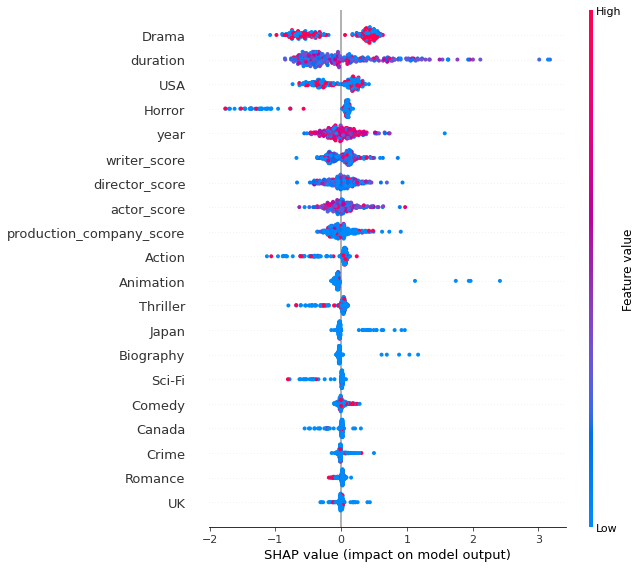

In [68]:
shap_values = explainer.shap_values(X_test.iloc[:300])
shap.summary_plot(shap_values, X_train.iloc[:300])

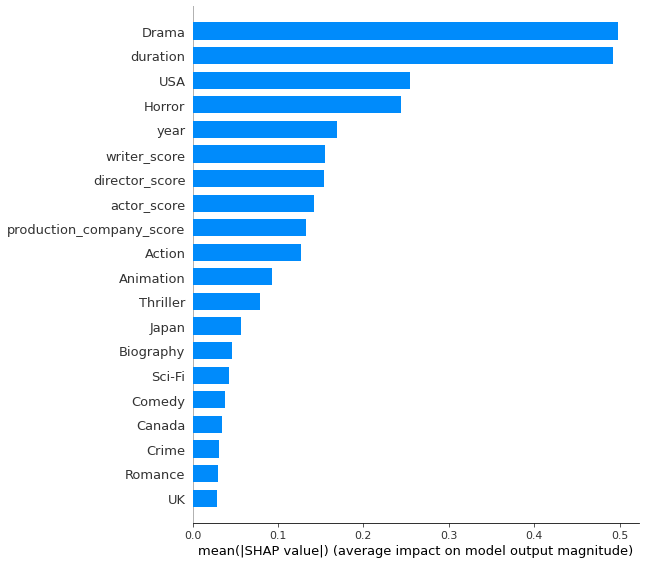

In [69]:
shap.summary_plot(shap_values, X_train.iloc[:300], plot_type="bar")

상위 영향력으로 계산된 feature들을 분석하면 다음과 같다.
1. drama : 드라마 장르가 영화 추천에 긍정적인 영향을 끼쳤다.
2. duration : 상영시간이 100분정도 이상인 영화들이 좋은 평가를 받았다.
3. USA : 미국 영화인 경우, 부정적인 영향을 끼쳤다.
4. Horror : 호러 장르가 영화 추천에 부정적인 영향을 끼쳤다.

#이제 위 모델을 바탕으로 다음과 같은 시나리오를 가정하고 영화를 추천해보자
- 현재 중국에서 런칭한 Netflix 벤치마킹 기업, Maoflix에서 스트리밍 서비스에 영화를 등록하고, 유저들에게 추천하려고 한다.
- 위 데이터의 train,validation set으로 model을 학습하였다.
- test set로 활용한 새로운 영화 4000개가 스트리밍에 새로 등록된다고 하자
- 이제 test set의 영화정보(평점정보는 알 수 없다고 가정)를 바탕으로 추천 영화들을 분류하고 유저들에게 추천하자.

In [70]:
# 높은 y_pred_proba로 계산된 영화를 먼저 추천하는 것이 좋다 
y_pred_proba = pipe.predict_proba(X_test)
y_pred_proba

array([[0.9262636 , 0.07373644],
       [0.90802234, 0.09197767],
       [0.59749985, 0.40250012],
       ...,
       [0.2367366 , 0.7632634 ],
       [0.96170455, 0.03829543],
       [0.9788615 , 0.02113851]], dtype=float32)

In [103]:
df_movies = pd.read_csv('/content/drive/My Drive/Code/IMDb movies.csv')
movie_names = df_movies['original_title'].loc[X_test.index]

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.


In [117]:
temp = pd.Series(y_pred_proba[:,1],list(movie_names))
temp.sort_values(ascending=False).head(10)

Ba wang bie ji                                               0.996280
Forest of the Dead Sharks                                    0.996279
Billy Elliot the Musical Live                                0.995163
Cursed forest                                                0.993794
Doraemon: Nobita to Animaru puranetto                        0.982634
Doraemon: Nobita to Kumo no ôkoku                            0.981993
Boyhood                                                      0.969348
Gekijouban Bureiku bureido Dairokushou: Doukoku no toride    0.962682
The Lion King                                                0.959499
Carla's Song                                                 0.959102
dtype: float32

상위 prob로 나열했을 때 위와 같은 영화들이 추천되었음을 알 수 있다.

모델의 한계점  
1. description에 영화에 소재, 주제에 대한 다양한 정보가 있었는데, text정보라서 이것을 활용하지 못했다. 추후 NLP 알고리즘으로 이 정보도 반영할 수 있는 모델을 만들 수 있을 것이다.
2. 영화 개봉정보는 시계열 데이터의 속성을 가지고 있다(배우, 감독, 각본가들은 소위 말하는 전성기, 쇠퇴기를 가지고 있다.) 이 정보를 제대로 반영하지 못한다면 최신 영화들을 분류하는데에 있어서 엄밀하지 못할 것이다.
3. 영화를 추천받는 유저의 취향 정보가 추가된다면 추천 영화들 중에서도 유저의 취향에 부합하는 영화들을 추가로 필터링하여 더 신뢰할 수 있는 추천을 할 수 있을 것이다